# Kmeans Results

#### Extract computation time from different computational models

In [40]:
import pandas as pd
import numpy as np

# Example random data (same as the one you wanted to generate)
input_files = ["input_file_1", "input_file_2", "input_file_3"]
models = ["sequential", "cuda", "cudaV2", "mpi_openmp_2_2"]

# Initialize an empty list to store the random data
plot_data = []

# Create random data for execution times (in seconds)
np.random.seed(42)  # For reproducibility

for input_file in input_files:
    for model in models:
        # Generate random execution times for each model and input file
        num_samples = 10  # Number of samples per model and input file
        execution_times = np.random.uniform(0.5, 5.0, num_samples)  # Random times between 0.5 and 5 seconds
        
        # Add the data for each sample
        for exec_time in execution_times:
            plot_data.append({
                "model": model,
                "input_file": input_file,
                "execution_time": exec_time
            })

# Create a DataFrame from the random data
result_df = pd.DataFrame(plot_data)

# Display the first few rows of the DataFrame
print(result_df.head())

        model    input_file  execution_time
0  sequential  input_file_1        2.185431
1  sequential  input_file_1        4.778214
2  sequential  input_file_1        3.793973
3  sequential  input_file_1        3.193963
4  sequential  input_file_1        1.202084


### Plot computational time with respect to sequential model for each other model

In [ ]:
import os
import pandas as pd

RESULTS_DIR = "./results"  # Directory containing your results

# A function to extract time data from a given file
def extract_times_from_file(file_path):
    time = -1
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("Computation:"):
                time = (float(line.split(" ")[-2].strip()))
                break
    return time

# Loop over the results folder and extract data from .out files
def load_results():
    data = []
    for model in os.listdir(RESULTS_DIR): # sequential, cuda, ecc..
        model_folder = os.path.join(RESULTS_DIR, model)

        if not os.path.isdir(model_folder):
            continue

        for input_file in os.listdir(model_folder): # results/model/input100D.inp_clusters_x/
            input_file_folder = os.path.join(model_folder, input_file)

            if not os.path.isdir(input_file_folder):
                continue

            for iteration_file in os.listdir(input_file_folder): # results/model/input100D.inp_clusters_x/i.out/log
                if iteration_file.endswith(".log"):
                    file_path = os.path.join(input_file_folder, iteration_file)
                    time = extract_times_from_file(file_path)
                    data.append({
                        'model': model,
                        'input_file': input_file,
                        'execution_time': time
                    })
    return pd.DataFrame(data)

result_df = load_results()
result_df.head()

""


### Computational time of models per input file

/var/folders/lv/jlxzlzp13vn46h23m60bldl80000gn/T/ipykernel_21145/3756522418.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




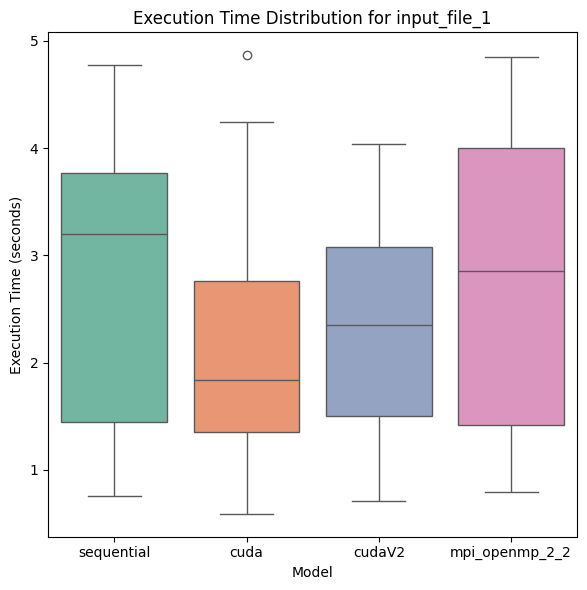

/var/folders/lv/jlxzlzp13vn46h23m60bldl80000gn/T/ipykernel_21145/3756522418.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




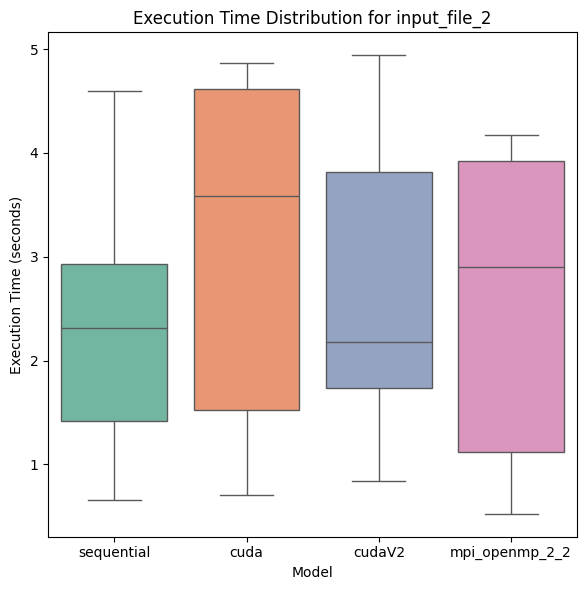

/var/folders/lv/jlxzlzp13vn46h23m60bldl80000gn/T/ipykernel_21145/3756522418.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




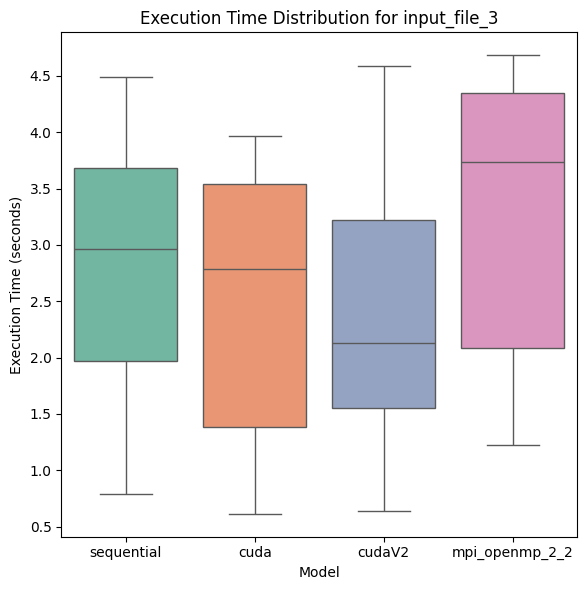

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming result_df is already created with random data as shown earlier

# List of input files
input_files = result_df["input_file"].unique()

# Plotting each input file separately
for input_file in input_files:
    plt.figure(figsize=(6, 6))
    
    # Filter data for the current input file
    filtered_data = result_df[result_df["input_file"] == input_file]

    # Create a boxplot using Seaborn
    sns.boxplot(data=filtered_data, x="model", y="execution_time", palette="Set2")
    
    # Add labels and title
    plt.xlabel("Model")
    plt.ylabel("Execution Time (seconds)")
    plt.title(f"Execution Time Distribution for {input_file}")
    
    # Show the plot
    plt.tight_layout()
    plt.show()


### Speedups with respect to Sequential model

In [42]:
import pandas as pd
from tabulate import tabulate

# Filter out data for sequential and other models
sequential_data = result_df[result_df["model"] == "sequential"]

# Initialize an empty list to store speedup data
speedup_data = []

# Loop over all models excluding sequential
models_to_compare = result_df["model"].unique()
models_to_compare = [model for model in models_to_compare if model != "sequential"]

# Calculate speedup for each model relative to sequential
for model in models_to_compare:
    # Filter data for the current model
    model_data = result_df[result_df["model"] == model]
    
    # Merge the sequential data with the current model data based on input file
    merged_data = pd.merge(sequential_data, model_data, on=["input_file"], suffixes=("_seq", "_model"))
    
    # Calculate speedup
    merged_data["speedup"] = merged_data["execution_time_seq"] / merged_data["execution_time_model"]
    
    # Add the model and speedup data to the list
    for input_file in merged_data["input_file"].unique():
        speedup_data.append({
            "input_file": input_file,
            "model": model,
            "speedup": merged_data[merged_data["input_file"] == input_file]["speedup"].mean()  # Take the mean speedup for each input file
        })

# Create a DataFrame from the speedup data
speedup_df = pd.DataFrame(speedup_data)

# Pivot the table to get models as rows and input files as columns
speedup_table = speedup_df.pivot(index="model", columns="input_file", values="speedup")

# Print the formatted table using tabulate
print("Speedup of Models Relative to Sequential Model:")
print(tabulate(speedup_table, headers='keys', tablefmt='pretty', showindex=True))


Speedup of Models Relative to Sequential Model:
+----------------+--------------------+--------------------+--------------------+
|     model      |    input_file_1    |    input_file_2    |    input_file_3    |
+----------------+--------------------+--------------------+--------------------+
|      cuda      | 1.7539890386493397 | 1.203156662401149  | 1.6708671443409033 |
|     cudaV2     | 1.6040921795340544 | 1.1992688848759228 | 1.7414296288586493 |
| mpi_openmp_2_2 | 1.5052002454192606 | 1.5209652687286532 | 1.1160386429590063 |
+----------------+--------------------+--------------------+--------------------+


### Scalability of mpi_omp models

Speedup of mpi_openmp Models Relative to Sequential Model:
+----------------+--------------------+--------------------+--------------------+
|     model      |    input_file_1    |    input_file_2    |    input_file_3    |
+----------------+--------------------+--------------------+--------------------+
| mpi_openmp_2_2 | 1.5052002454192606 | 1.5209652687286532 | 1.1160386429590063 |
+----------------+--------------------+--------------------+--------------------+

Strong Scaling of mpi_openmp Models:
+----------------+--------------+--------------+--------------+
|     model      | input_file_1 | input_file_2 | input_file_3 |
+----------------+--------------+--------------+--------------+
| mpi_openmp_2_2 |     0.5      |     0.5      |     0.5      |
+----------------+--------------+--------------+--------------+

Weak Scaling of mpi_openmp Models:
+----------------+--------------+--------------+--------------+
|     model      | input_file_1 | input_file_2 | input_file_3 |
+--------

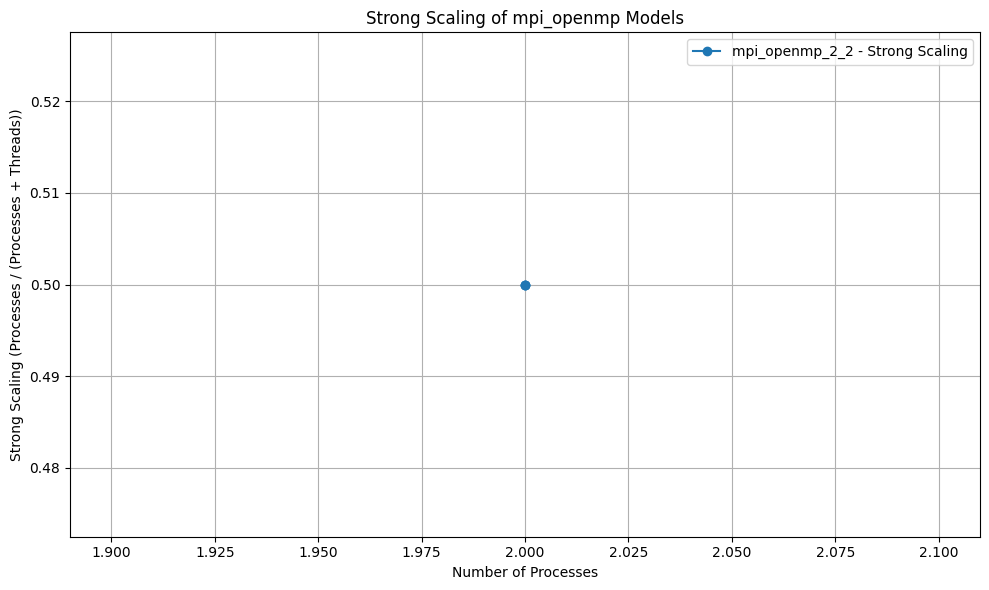

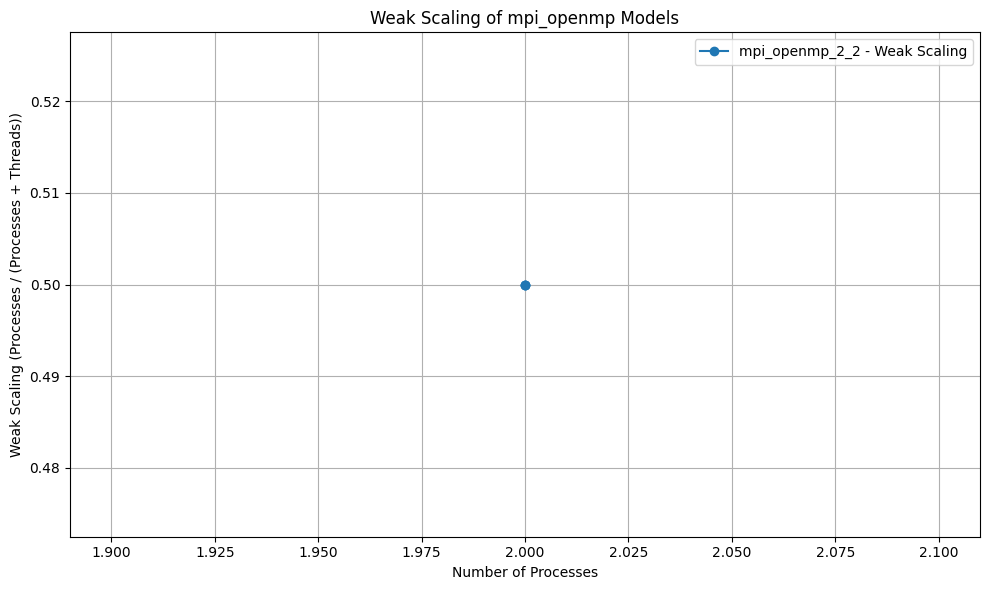

In [45]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

# Filter out mpi_openmp models
mpi_openmp_data = result_df[result_df["model"].str.startswith("mpi_openmp")]

# Extract sequential data for comparison
sequential_data = result_df[result_df["model"] == "sequential"]

# Initialize an empty list to store speedup data
speedup_data_mpi_openmp = []

# Loop over all mpi_openmp models
for model in mpi_openmp_data["model"].unique():
    # Filter data for the current mpi_openmp model
    model_data = mpi_openmp_data[mpi_openmp_data["model"] == model]
    
    # Merge the sequential data with the current mpi_openmp model data based on input file
    merged_data = pd.merge(sequential_data, model_data, on=["input_file"], suffixes=("_seq", "_model"))
    
    # Calculate speedup
    merged_data["speedup"] = merged_data["execution_time_seq"] / merged_data["execution_time_model"]
    
    # Extract the number of processes and threads from the model name
    num_processes, num_threads = map(int, model.split("_")[-2:])
    
    # Calculate strong and weak scaling
    merged_data["strong_scaling"] = num_processes / (num_processes + num_threads)
    merged_data["weak_scaling"] = num_processes / (num_processes + num_threads)
    
    # Add the model, number of processes, number of threads, speedup, and scaling data to the list
    for input_file in merged_data["input_file"].unique():
        speedup_data_mpi_openmp.append({
            "input_file": input_file,
            "num_processes": num_processes,
            "num_threads": num_threads,
            "model": model,
            "speedup": merged_data[merged_data["input_file"] == input_file]["speedup"].mean(),  # Take the mean speedup for each input file
            "strong_scaling": merged_data[merged_data["input_file"] == input_file]["strong_scaling"].mean(),
            "weak_scaling": merged_data[merged_data["input_file"] == input_file]["weak_scaling"].mean()
        })

# Create a DataFrame from the speedup data
speedup_df_mpi_openmp = pd.DataFrame(speedup_data_mpi_openmp)

# Pivot the table to get models as rows and input files as columns for speedup, strong scaling, and weak scaling
speedup_table_mpi_openmp = speedup_df_mpi_openmp.pivot(index="model", columns="input_file", values="speedup")
strong_scaling_table = speedup_df_mpi_openmp.pivot(index="model", columns="input_file", values="strong_scaling")
weak_scaling_table = speedup_df_mpi_openmp.pivot(index="model", columns="input_file", values="weak_scaling")

# Print the formatted tables using tabulate
print("Speedup of mpi_openmp Models Relative to Sequential Model:")
print(tabulate(speedup_table_mpi_openmp, headers='keys', tablefmt='pretty', showindex=True))

print("\nStrong Scaling of mpi_openmp Models:")
print(tabulate(strong_scaling_table, headers='keys', tablefmt='pretty', showindex=True))

print("\nWeak Scaling of mpi_openmp Models:")
print(tabulate(weak_scaling_table, headers='keys', tablefmt='pretty', showindex=True))

# Now analyze scalability based on strong scaling

# Plot Strong Scaling
plt.figure(figsize=(10, 6))
for model in speedup_df_mpi_openmp["model"].unique():
    model_data = speedup_df_mpi_openmp[speedup_df_mpi_openmp["model"] == model]
    plt.plot(model_data["num_processes"], model_data["strong_scaling"], marker="o", label=f"{model} - Strong Scaling")

plt.xlabel("Number of Processes")
plt.ylabel("Strong Scaling (Processes / (Processes + Threads))")
plt.title("Strong Scaling of mpi_openmp Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Now analyze scalability based on weak scaling

# Plot Weak Scaling
plt.figure(figsize=(10, 6))
for model in speedup_df_mpi_openmp["model"].unique():
    model_data = speedup_df_mpi_openmp[speedup_df_mpi_openmp["model"] == model]
    plt.plot(model_data["num_processes"], model_data["weak_scaling"], marker="o", label=f"{model} - Weak Scaling")

plt.xlabel("Number of Processes")
plt.ylabel("Weak Scaling (Processes / (Processes + Threads))")
plt.title("Weak Scaling of mpi_openmp Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
